In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
import os
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
import shap

from lib.lib import Import_data

path = Import_data()
# get all files in the directory
files = os.listdir(path)
print(files)

Path to dataset files: /home/kristian/.cache/kagglehub/datasets/arashnic/earthquake-magnitude-damage-and-impact/versions/6
['ward_vdcmun_district_name_mapping.csv', 'csv_building_ownership_and_use.csv', 'csv_household_resources.csv', 'csv_building_damage_assessment.csv', 'csv_individual_demographics.csv', 'csv_building_structure.csv', 'mapping.csv', 'csv_household_demographics.csv', 'csv_household_earthquake_impact.csv']


In [137]:
building_structure = pd.read_csv(path + "/csv_building_structure.csv")
dmg_assesment = pd.read_csv(path + "/csv_building_damage_assessment.csv")

building_structure.keys()

/tmp/ipykernel_62557/4115963309.py:2: DtypeWarning: Columns (5,17,29,34,35,36,37,38,39,40,41,42,43,47,50) have mixed types. Specify dtype option on import or set low_memory=False.


Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed'],
      dtype='object')

In [138]:
# Filter out uneeded rows
dmg_assesment = dmg_assesment.drop(columns=[col for col in dmg_assesment.columns if 'has_geotechnical_risk' != col and col != 'building_id'])

In [141]:
# Merge dmg assesment into building structure on building id column
building_structure = building_structure.merge(dmg_assesment, on='building_id')
building_structure.keys()

Index(['building_id', 'district_id', 'vdcmun_id', 'ward_id',
       'count_floors_pre_eq', 'count_floors_post_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq', 'height_ft_post_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'condition_post_eq', 'damage_grade', 'technical_solution_proposed',
       'has_geotechnical_risk'],
      dtype='object')

In [142]:
# Remove id columns, columns containing post_eq and technical_solution_proposed and position
building_structure = building_structure.drop(columns=[col for col in building_structure.columns if 'id' in col or 'post_eq' in col or 'technical_solution_proposed' in col in col])

In [143]:
# Dropping floors above 6
building_structure = building_structure[building_structure["count_floors_pre_eq"] < 6]

In [144]:
# Dropping rows with plinith area above 1500
building_structure = building_structure[building_structure["plinth_area_sq_ft"] <= 1500]

In [145]:
# Changing damage categories into numerical values
building_structure["damage_grade"] = building_structure["damage_grade"].replace({"Grade 1": 0, "Grade 2": 1, "Grade 3": 2, "Grade 4": 3, "Grade 5": 4})

/tmp/ipykernel_62557/555852273.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [146]:
# Translating category columns to category type for native category support
categorical_columns = [
    "land_surface_condition", 
    "foundation_type", 
    "roof_type", 
    "ground_floor_type",
    "other_floor_type",
    "plan_configuration",
]

for col in categorical_columns:
    building_structure[col] = building_structure[col].astype('category')

In [147]:
print(building_structure.isna().sum())
building_structure = building_structure.dropna()

count_floors_pre_eq                        0
age_building                               0
plinth_area_sq_ft                          0
height_ft_pre_eq                           0
land_surface_condition                     0
foundation_type                            0
roof_type                                  0
ground_floor_type                          0
other_floor_type                           0
position                                   1
plan_configuration                         1
has_superstructure_adobe_mud               0
has_superstructure_mud_mortar_stone        0
has_superstructure_stone_flag              0
has_superstructure_cement_mortar_stone     0
has_superstructure_mud_mortar_brick        0
has_superstructure_cement_mortar_brick     0
has_superstructure_timber                  0
has_superstructure_bamboo                  0
has_superstructure_rc_non_engineered       0
has_superstructure_rc_engineered           0
has_superstructure_other                   0
damage_gra

In [148]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def train(X_train, y_train, X_val, y_val,params, rounds):
    # Create the LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=rounds,
        valid_sets=[train_data, val_data],
    )

    return model

In [149]:
def test_classification(model, X_test, y_test, keys):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_class)
    balanced_acc = balanced_accuracy_score(y_test, y_pred_class)
    report = classification_report(y_test, y_pred_class)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print("Classification Report:")
    print(report)

    # Feature importance
    importance = model.feature_importance(importance_type='split')
    feature_names = keys
    feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

    print("Feature Importance (top 10):")
    for feature, importance in feature_importance[:10]:
        print(f"{feature}: {importance}")

    return accuracy, balanced_acc, feature_importance

In [150]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def test_regression(model, X, y_true):
    y_pred = model.predict(X)

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

In [151]:
categorical_columns = [
    # 'land_surface_condition', 
    'foundation_type', 
    'roof_type', 
    'ground_floor_type', 
    'other_floor_type', 
    'position'
    #'plan_configuration'
]

building_structure["height_plinth_ratio"] = building_structure["height_ft_pre_eq"] / building_structure["plinth_area_sq_ft"]
building_structure = building_structure[building_structure["height_plinth_ratio"] < 0.3]

# I want to combine these: 'roof_type_Bamboo/Timber-Heavy roof', 'roof_type_Bamboo/Timber-Light roof'
# They are both in the roof type column. Create a new category thats called Bamboo/Timber
building_structure["roof_type"] = building_structure["roof_type"].replace({"Bamboo/Timber-Heavy roof": "Bamboo/Timber", "Bamboo/Timber-Light roof": "Bamboo/Timber"})

to_drop = [
    "damage_grade",
    "plinth_area_sq_ft",
    "height_ft_pre_eq",
    "plan_configuration",
    "land_surface_condition",
    #"position",
    #"count_floors_pre_eq",
]

# Use pandas get_dummies function to one-hot encode
X = pd.get_dummies(
    building_structure.drop(columns=to_drop), 
    columns=categorical_columns,
    drop_first=False,  # Set to True if you want to avoid multicollinearity
    prefix=categorical_columns,
    prefix_sep='_'
)

/tmp/ipykernel_62557/160654600.py:16: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


In [152]:
keys = X.keys()
X = X.to_numpy()

y = building_structure["damage_grade"].astype("Int64").to_numpy()
# y 0 is 0, 1 is 1, 2 is 1, 3 is 1, 4 is 2
# y = np.where(y == 0, 0, np.where(y == 1, 1, np.where(y == 2, 1, np.where(y == 3, 1, 2))))

# 3 to 1. 
y = np.where(y <= 1, 0, np.where(y == 2, 1, 2))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Original training distribution:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Sampled training distribution:", Counter(y_train))

Original training distribution: Counter({np.int64(2): 320948, np.int64(0): 114441, np.int64(1): 95120})
Sampled training distribution: Counter({np.int64(2): 320948, np.int64(0): 320948, np.int64(1): 320948})


In [153]:
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # Number of damage grade classes
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': -1,        # -1 means no limit
    'num_leaves': 31,       # Maximum tree leaves for base learners
    'feature_fraction': 0.8, # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8, # Randomly select a subset of data without resampling
    'bagging_freq': 5,       # Perform bagging every 5 iterations
    'verbose': -1,          # Suppress printing messages
    'boosting_type': 'gbdt',  # Traditional Gradient Boosting Decision Tree
}

rounds=1000

model = train(X_train, y_train, X_val, y_val, params, rounds)

In [154]:
accuracy, bacc, feature_importance = test_classification(model, X_test, y_test, keys=keys)
print("accuracy:", accuracy)
print("Balanced accuracy", bacc)
# Print the top 10 and the bot 10 important features
print("\nFeature Importance (bottom 10):")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.6242
Balanced Accuracy: 0.5460
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62     24553
           1       0.25      0.31      0.28     20278
           2       0.76      0.72      0.74     68850

    accuracy                           0.62    113681
   macro avg       0.55      0.55      0.55    113681
weighted avg       0.64      0.62      0.63    113681

Feature Importance (top 10):
height_plinth_ratio: 18318
age_building: 15326
count_floors_pre_eq: 5244
has_superstructure_timber: 3755
has_geotechnical_risk: 3550
has_superstructure_mud_mortar_stone: 3174
has_superstructure_bamboo: 2672
has_superstructure_adobe_mud: 2245
other_floor_type_TImber/Bamboo-Mud: 2215
position_Not attached: 2211
accuracy: 0.6242467958585868
Balanced accuracy 0.5460191273193472

Feature Importance (bottom 10):
height_plinth_ratio: 18318
age_building: 15326
count_floors_pre_eq: 5244
has_superstructure_timber: 3755
has_geote

Accuracy: 0.6242467958585868
Balanced Accuracy: 0.5460191273193472


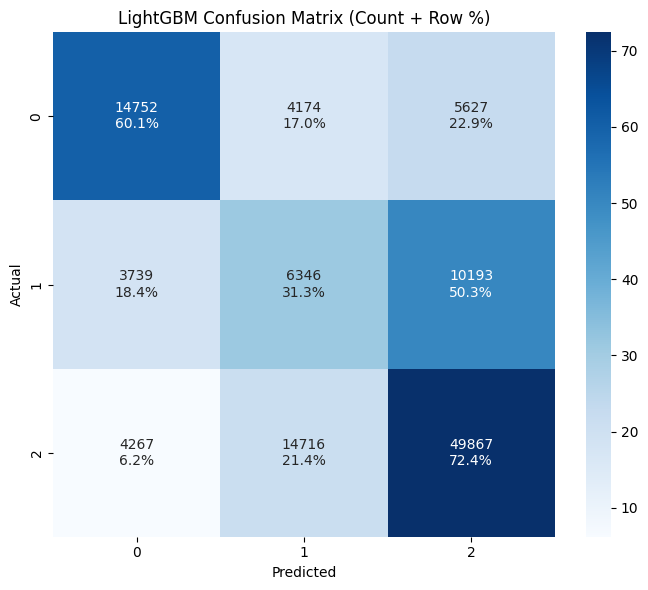

In [155]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

probs = model.predict(X_test)
if probs.ndim == 2:  # shape (n_samples, n_classes)
    y_pred = np.argmax(probs, axis=1)
else:
    y_pred = probs

# Metrics
acc = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Balanced Accuracy:", balanced_acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

# Annotate with raw + %
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{count}\n{percent:.1f}%"

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(cm_normalized, annot=annot, fmt='', cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LightGBM Confusion Matrix (Count + Row %)")
plt.tight_layout()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

regression_params = {
    'objective': 'regression',        # Changed to regression
    'metric': 'mae',                 # Changed to RMSE (root mean squared error)
    'learning_rate': 0.1,
    'max_depth': -1,                  # -1 means no limit
    'num_leaves': 31,                 # Maximum tree leaves for base learners
    'feature_fraction': 0.8,          # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8,          # Randomly select a subset of data without resampling
    'bagging_freq': 5,                # Perform bagging every 5 iterations
    'verbose': -1,                    # Suppress printing messages
    'device_type:': 'cuda',            # Use GPU for training
    'n_estimators': 4000,             # Number of boosting iterations
    'boosting_type': 'gbdt'           # Traditional Gradient Boosting Decision Tree
}

rounds = 1000
reg_model = train(X_train, y_train, X_val, y_val, regression_params, rounds)
print(
test_regression(reg_model, X_test, y_test)
)

{'MSE': 0.5023130760976071, 'MAE': 0.6040982445396839, 'R2': 0.25004205875416274}


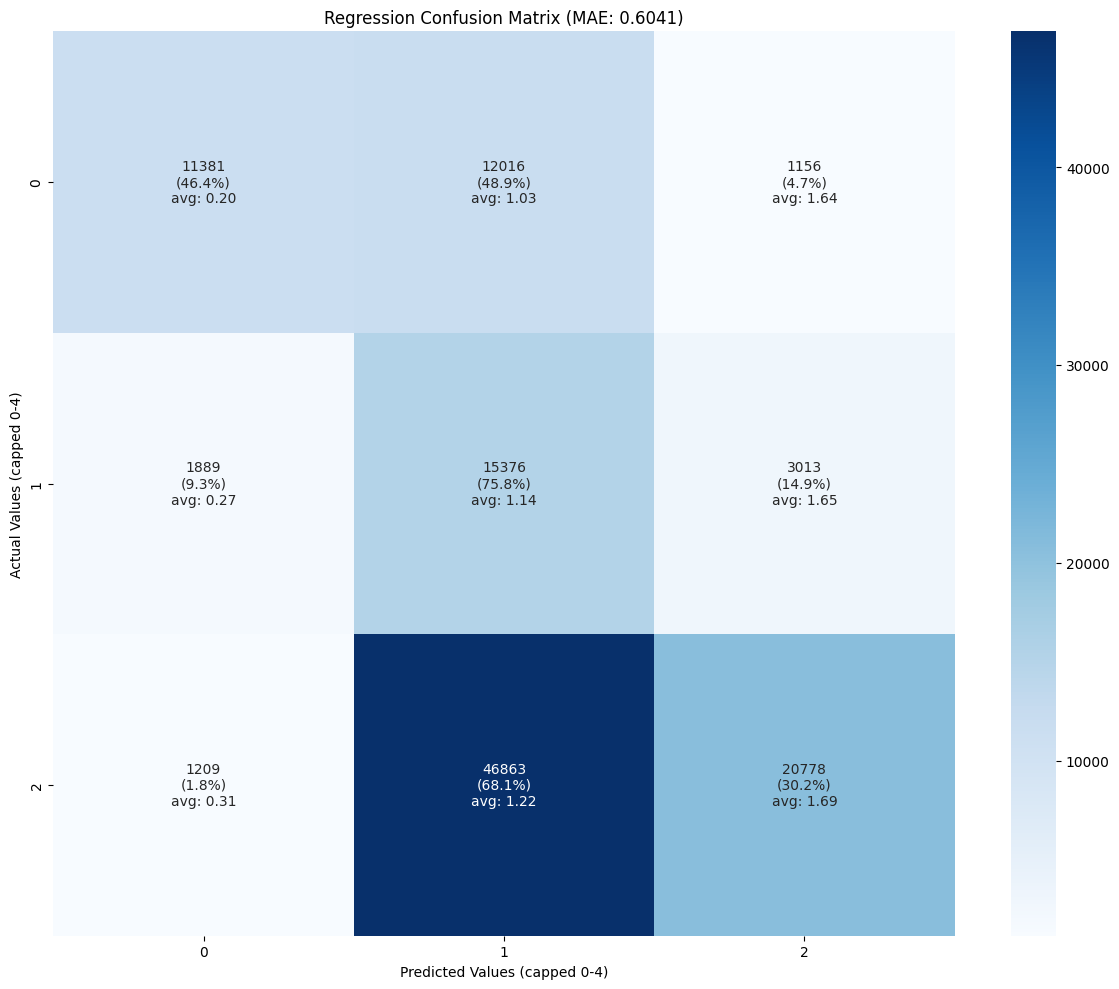

Original MAE (before capping): 0.6041
Overall accuracy (after capping and rounding): 41.81%

Average prediction by true class:
  True class 0: avg prediction = 0.67
  True class 1: avg prediction = 1.14
  True class 2: avg prediction = 1.35


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_absolute_error

# Get predictions
y_pred_test = reg_model.predict(X_test)

# Calculate MAE (on original predictions, before capping)
mae = mean_absolute_error(y_test, y_pred_test)

# Cap values between 0 and 4 for both actual and predicted values
y_test_capped = np.clip(y_test, 0, 2)
y_pred_capped = np.clip(y_pred_test, 0, 2)

# Convert regression values to integers using traditional rounding
y_test_int = np.floor(y_test_capped + 0.5).astype(int)
y_pred_int = np.floor(y_pred_capped + 0.5).astype(int)

# Get unique classes (all possible integer values, should be 0,1,2,3,4)
all_classes = np.array([0, 1, 2])  # Explicitly define to ensure all classes are included

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int, labels=all_classes)

# Calculate percentages for each cell (accuracy within each true class)
row_sums = cm.sum(axis=1)[:, np.newaxis]
row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
cm_percent = cm.astype('float') / row_sums * 100

# Calculate average predicted values for each cell in the confusion matrix
avg_pred_values = np.zeros_like(cm, dtype=float)

for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        # Find indices where true class is i and predicted class (after rounding) is j
        mask = (y_test_int == all_classes[i]) & (y_pred_int == all_classes[j])
        if np.sum(mask) > 0:
            # Calculate average of the original regression predictions for these instances
            avg_pred_values[i, j] = np.mean(y_pred_test[mask])
        else:
            avg_pred_values[i, j] = np.nan

# Create a formatted annotation matrix combining counts, percentages, and average predicted values
annot = np.empty_like(cm, dtype=object)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if not np.isnan(avg_pred_values[i, j]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: {avg_pred_values[i, j]:.2f}"
        else:
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: N/A"

# Plot with combined annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.title(f'Regression Confusion Matrix (MAE: {mae:.4f})')
plt.xlabel('Predicted Values (capped 0-4)')
plt.ylabel('Actual Values (capped 0-4)')
plt.tight_layout()
plt.show()

# Calculate overall accuracy from confusion matrix
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Original MAE (before capping): {mae:.4f}")
print(f"Overall accuracy (after capping and rounding): {overall_accuracy:.2f}%")

# Display additional statistics about predictions by true class
print("\nAverage prediction by true class:")
for cls in all_classes:
    mask = y_test_int == cls
    if np.sum(mask) > 0:
        avg_pred = np.mean(y_pred_test[mask])
        print(f"  True class {cls}: avg prediction = {avg_pred:.2f}")

In [ ]:
# give me a random forest classifier on x and y train
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=30, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.51      0.56      0.54     24553
           1       0.23      0.29      0.25     20278
           2       0.74      0.66      0.70     68850

    accuracy                           0.57    113681
   macro avg       0.49      0.50      0.50    113681
weighted avg       0.60      0.57      0.58    113681



Accuracy: 0.5707374143436458
Balanced Accuracy: 0.5023718949634461


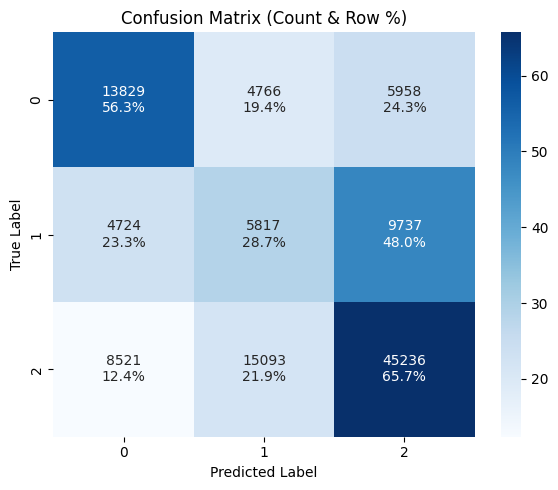

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict and calculate metrics
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

# Combine raw and percentage into formatted strings
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{count}\n{percent:.1f}%"

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=annot, fmt='', cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Count & Row %)")
plt.tight_layout()
plt.show()



In [ ]:
# now do a random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor(n_estimators=10, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("mse;", mean_squared_error(y_test, y_pred))
print("mae;", mean_absolute_error(y_test, y_pred))

mse; 0.5834204831121067
mae; 0.5745544531514158


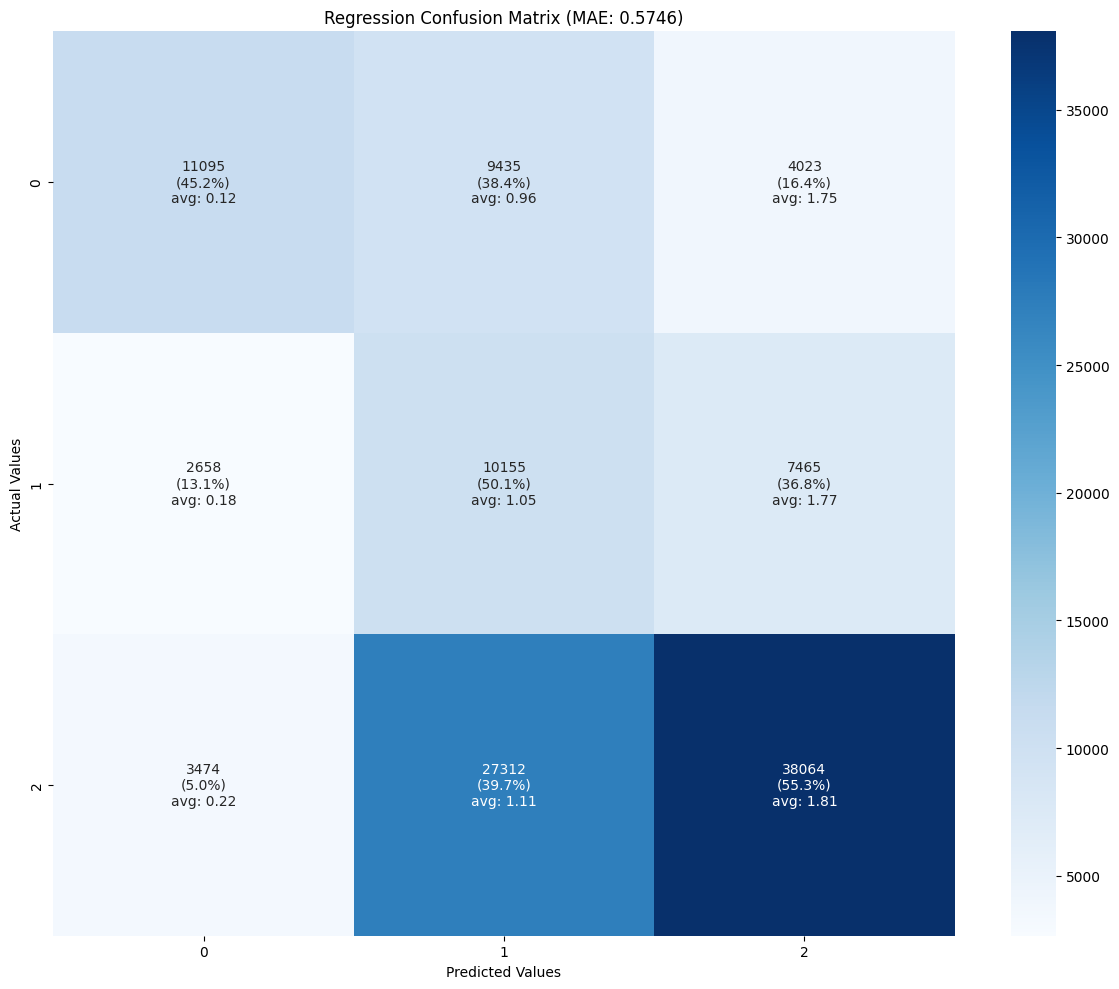

Original MAE (before capping): 0.5746
Overall accuracy (after capping and rounding): 52.18%

Average prediction by true class:
  True class 0: avg prediction = 0.71
  True class 1: avg prediction = 1.20
  True class 2: avg prediction = 1.45


In [ ]:
y_pred_test = y_pred

mae = mean_absolute_error(y_test, y_pred_test)

# Cap values between 0 and 4 for both actual and predicted values
y_test_capped = np.clip(y_test, 0, 2)
y_pred_capped = np.clip(y_pred_test, 0, 2)

# Convert regression values to integers using traditional rounding
y_test_int = np.floor(y_test_capped + 0.5).astype(int)
y_pred_int = np.floor(y_pred_capped + 0.5).astype(int)

# Get unique classes (all possible integer values, should be 0,1,2,3,4)
all_classes = np.array([0, 1, 2])  # Explicitly define to ensure all classes are included

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int, labels=all_classes)

# Calculate percentages for each cell (accuracy within each true class)
row_sums = cm.sum(axis=1)[:, np.newaxis]
row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
cm_percent = cm.astype('float') / row_sums * 100

# Calculate average predicted values for each cell in the confusion matrix
avg_pred_values = np.zeros_like(cm, dtype=float)

for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        # Find indices where true class is i and predicted class (after rounding) is j
        mask = (y_test_int == all_classes[i]) & (y_pred_int == all_classes[j])
        if np.sum(mask) > 0:
            # Calculate average of the original regression predictions for these instances
            avg_pred_values[i, j] = np.mean(y_pred_test[mask])
        else:
            avg_pred_values[i, j] = np.nan

# Create a formatted annotation matrix combining counts, percentages, and average predicted values
annot = np.empty_like(cm, dtype=object)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if not np.isnan(avg_pred_values[i, j]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: {avg_pred_values[i, j]:.2f}"
        else:
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: N/A"

# Plot with combined annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.title(f'Regression Confusion Matrix (MAE: {mae:.4f})')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.tight_layout()
plt.show()

# Calculate overall accuracy from confusion matrix
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Original MAE (before capping): {mae:.4f}")
print(f"Overall accuracy (after capping and rounding): {overall_accuracy:.2f}%")

# Display additional statistics about predictions by true class
print("\nAverage prediction by true class:")
for cls in all_classes:
    mask = y_test_int == cls
    if np.sum(mask) > 0:
        avg_pred = np.mean(y_pred_test[mask])
        print(f"  True class {cls}: avg prediction = {avg_pred:.2f}")

In [156]:
y = building_structure["damage_grade"].astype("Int64").to_numpy()


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Original training distribution:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Sampled training distribution:", Counter(y_train))

Original training distribution: Counter({np.int64(4): 192699, np.int64(3): 128249, np.int64(2): 95120, np.int64(1): 60396, np.int64(0): 54045})
Sampled training distribution: Counter({np.int64(3): 192699, np.int64(4): 192699, np.int64(1): 192699, np.int64(2): 192699, np.int64(0): 192699})


In [ ]:
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y)),  # Number of damage grade classes
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': -1,        # -1 means no limit
    'num_leaves': 31,       # Maximum tree leaves for base learners
    'feature_fraction': 0.8, # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8, # Randomly select a subset of data without resampling
    'bagging_freq': 5,       # Perform bagging every 5 iterations
    'verbose': -1,          # Suppress printing messages
    'boosting_type': 'gbdt',  # Traditional Gradient Boosting Decision Tree
}

rounds=1000

model = train(X_train, y_train, X_val, y_val, params, rounds)

In [ ]:
accuracy, bacc, feature_importance = test_classification(model, X_test, y_test, keys=keys)
print("accuracy:", accuracy)
print("Balanced accuracy", bacc)
# Print the top 10 and the bot 10 important features
print("\nFeature Importance (bottom 10):")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.4228
Balanced Accuracy: 0.3981
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57     11659
           1       0.24      0.18      0.21     12894
           2       0.28      0.21      0.24     20278
           3       0.34      0.32      0.33     27512
           4       0.53      0.60      0.56     41338

    accuracy                           0.42    113681
   macro avg       0.38      0.40      0.38    113681
weighted avg       0.40      0.42      0.41    113681

Feature Importance (top 10):
height_plinth_ratio: 29502
age_building: 27151
count_floors_pre_eq: 8725
has_superstructure_timber: 6221
has_geotechnical_risk: 5428
has_superstructure_mud_mortar_stone: 5187
has_superstructure_bamboo: 4388
position_Not attached: 3778
has_superstructure_cement_mortar_brick: 3604
other_floor_type_TImber/Bamboo-Mud: 3565
accuracy: 0.42276193911031745
Balanced accuracy 0.39810779347306025

Feature Importance (bottom

Accuracy: 0.42276193911031745
Balanced Accuracy: 0.39810779347306025


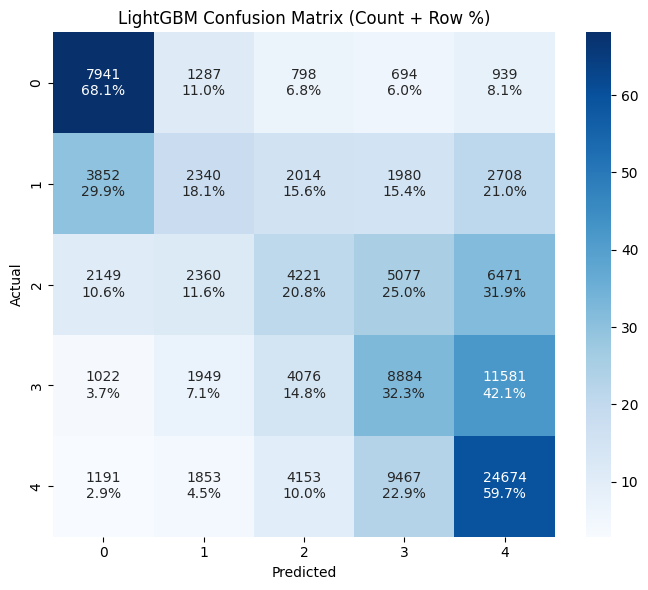

In [ ]:
# Force class prediction from probabilities if needed
probs = model.predict(X_test)
if probs.ndim == 2:  # shape (n_samples, n_classes)
    y_pred = np.argmax(probs, axis=1)
else:
    y_pred = probs

# Metrics
acc = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Balanced Accuracy:", balanced_acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

# Annotate with raw + %
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{count}\n{percent:.1f}%"

# Plot
plt.figure(figsize=(7, 6))
sns.heatmap(cm_normalized, annot=annot, fmt='', cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LightGBM Confusion Matrix (Count + Row %)")
plt.tight_layout()
plt.show()

Accuracy: 0.3635348035291737
Balanced Accuracy: 0.34844270428604085


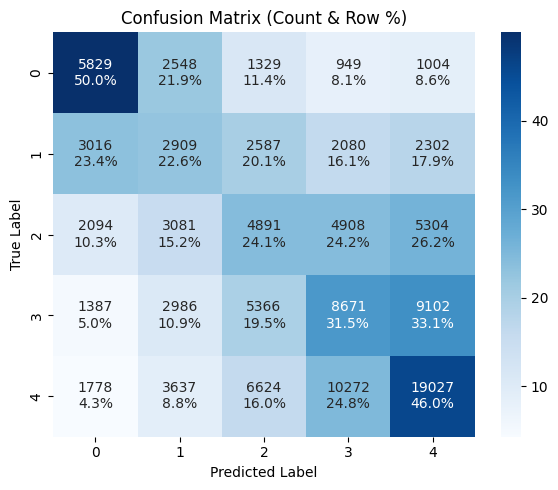

In [157]:
# give me a random forest classifier on x and y train
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=30, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict and calculate metrics
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100

# Combine raw and percentage into formatted strings
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_normalized[i, j]
        annot[i, j] = f"{count}\n{percent:.1f}%"

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=annot, fmt='', cmap="Blues",
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Count & Row %)")
plt.tight_layout()
plt.show()



mse; 1.4897265951667695
mae; 0.9525506985630967


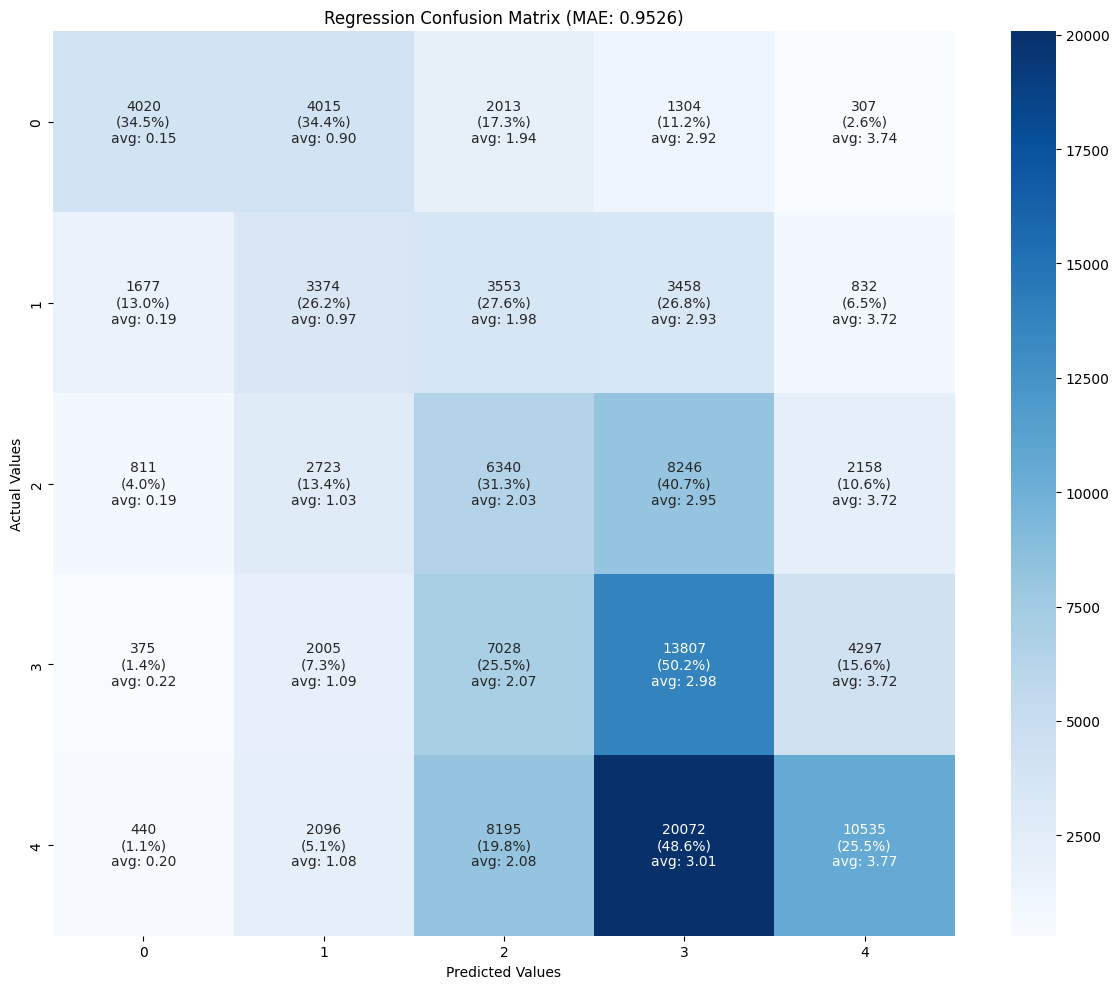

Original MAE (before capping): 0.9526
Overall accuracy (after capping and rounding): 33.49%

Average prediction by true class:
  True class 0: avg prediction = 1.12
  True class 1: avg prediction = 1.85
  True class 2: avg prediction = 2.38
  True class 3: avg prediction = 2.69
  True class 4: avg prediction = 2.89


In [160]:
# now do a random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

reg = RandomForestRegressor(n_estimators=10, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("mse;", mean_squared_error(y_test, y_pred))
print("mae;", mean_absolute_error(y_test, y_pred))
y_pred_test = y_pred

mae = mean_absolute_error(y_test, y_pred_test)

# Cap values between 0 and 4 for both actual and predicted values
y_test_capped = np.clip(y_test, 0, 4)
y_pred_capped = np.clip(y_pred_test, 0, 4)

# Convert regression values to integers using traditional rounding
y_test_int = np.floor(y_test_capped + 0.5).astype(int)
y_pred_int = np.floor(y_pred_capped + 0.5).astype(int)

# Get unique classes (all possible integer values, should be 0,1,2,3,4)
all_classes = np.array([0, 1, 2, 3, 4])  # Explicitly define to ensure all classes are included

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int, labels=all_classes)

# Calculate percentages for each cell (accuracy within each true class)
row_sums = cm.sum(axis=1)[:, np.newaxis]
row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
cm_percent = cm.astype('float') / row_sums * 100

# Calculate average predicted values for each cell in the confusion matrix
avg_pred_values = np.zeros_like(cm, dtype=float)

for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        # Find indices where true class is i and predicted class (after rounding) is j
        mask = (y_test_int == all_classes[i]) & (y_pred_int == all_classes[j])
        if np.sum(mask) > 0:
            # Calculate average of the original regression predictions for these instances
            avg_pred_values[i, j] = np.mean(y_pred_test[mask])
        else:
            avg_pred_values[i, j] = np.nan

# Create a formatted annotation matrix combining counts, percentages, and average predicted values
annot = np.empty_like(cm, dtype=object)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if not np.isnan(avg_pred_values[i, j]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: {avg_pred_values[i, j]:.2f}"
        else:
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: N/A"

# Plot with combined annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.title(f'Regression Confusion Matrix (MAE: {mae:.4f})')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.tight_layout()
plt.show()

# Calculate overall accuracy from confusion matrix
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Original MAE (before capping): {mae:.4f}")
print(f"Overall accuracy (after capping and rounding): {overall_accuracy:.2f}%")

# Display additional statistics about predictions by true class
print("\nAverage prediction by true class:")
for cls in all_classes:
    mask = y_test_int == cls
    if np.sum(mask) > 0:
        avg_pred = np.mean(y_pred_test[mask])
        print(f"  True class {cls}: avg prediction = {avg_pred:.2f}")

{'MSE': 1.2518792875207028, 'MAE': 0.9243246369828336, 'R2': 0.3032501652968077}


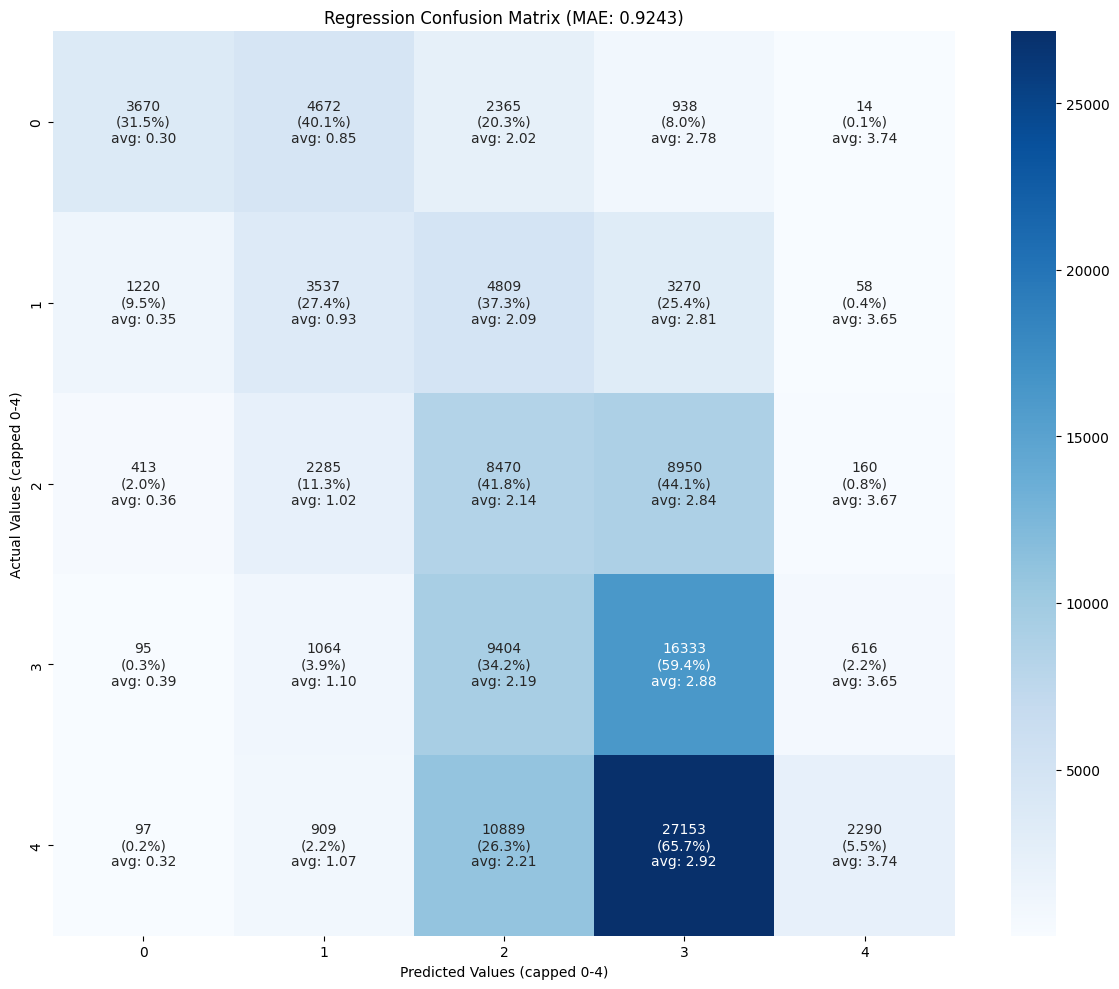

Original MAE (before capping): 0.9243
Overall accuracy (after capping and rounding): 30.17%

Average prediction by true class:
  True class 0: avg prediction = 1.07
  True class 1: avg prediction = 1.80
  True class 2: avg prediction = 2.30
  True class 3: avg prediction = 2.58
  True class 4: avg prediction = 2.73


In [159]:
from imblearn.over_sampling import SMOTE
from collections import Counter

regression_params = {
    'objective': 'regression',        # Changed to regression
    'metric': 'mae',                 # Changed to RMSE (root mean squared error)
    'learning_rate': 0.1,
    'max_depth': -1,                  # -1 means no limit
    'num_leaves': 31,                 # Maximum tree leaves for base learners
    'feature_fraction': 0.8,          # Randomly select a subset of features on each iteration
    'bagging_fraction': 0.8,          # Randomly select a subset of data without resampling
    'bagging_freq': 5,                # Perform bagging every 5 iterations
    'verbose': -1,                    # Suppress printing messages
    'device_type:': 'cuda',            # Use GPU for training
    'n_estimators': 4000,             # Number of boosting iterations
    'boosting_type': 'gbdt'           # Traditional Gradient Boosting Decision Tree
}

rounds = 1000
reg_model = train(X_train, y_train, X_val, y_val, regression_params, rounds)
print(
test_regression(reg_model, X_test, y_test)
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_absolute_error

# Get predictions
y_pred_test = reg_model.predict(X_test)

# Calculate MAE (on original predictions, before capping)
mae = mean_absolute_error(y_test, y_pred_test)

# Cap values between 0 and 4 for both actual and predicted values
y_test_capped = np.clip(y_test, 0, 4)
y_pred_capped = np.clip(y_pred_test, 0, 4)

# Convert regression values to integers using traditional rounding
y_test_int = np.floor(y_test_capped + 0.5).astype(int)
y_pred_int = np.floor(y_pred_capped + 0.5).astype(int)

# Get unique classes (all possible integer values, should be 0,1,2,3,4)
all_classes = np.array([0, 1, 2, 3, 4])  # Explicitly define to ensure all classes are included

# Create confusion matrix
cm = confusion_matrix(y_test_int, y_pred_int, labels=all_classes)

# Calculate percentages for each cell (accuracy within each true class)
row_sums = cm.sum(axis=1)[:, np.newaxis]
row_sums = np.where(row_sums == 0, 1, row_sums)  # Replace zeros with ones to avoid division by zero
cm_percent = cm.astype('float') / row_sums * 100

# Calculate average predicted values for each cell in the confusion matrix
avg_pred_values = np.zeros_like(cm, dtype=float)

for i in range(len(all_classes)):
    for j in range(len(all_classes)):
        # Find indices where true class is i and predicted class (after rounding) is j
        mask = (y_test_int == all_classes[i]) & (y_pred_int == all_classes[j])
        if np.sum(mask) > 0:
            # Calculate average of the original regression predictions for these instances
            avg_pred_values[i, j] = np.mean(y_pred_test[mask])
        else:
            avg_pred_values[i, j] = np.nan

# Create a formatted annotation matrix combining counts, percentages, and average predicted values
annot = np.empty_like(cm, dtype=object)
for i in range(len(cm)):
    for j in range(len(cm[i])):
        if not np.isnan(avg_pred_values[i, j]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: {avg_pred_values[i, j]:.2f}"
        else:
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)\navg: N/A"

# Plot with combined annotations
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
            xticklabels=all_classes, yticklabels=all_classes)
plt.title(f'Regression Confusion Matrix (MAE: {mae:.4f})')
plt.xlabel('Predicted Values (capped 0-4)')
plt.ylabel('Actual Values (capped 0-4)')
plt.tight_layout()
plt.show()

# Calculate overall accuracy from confusion matrix
overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
print(f"Original MAE (before capping): {mae:.4f}")
print(f"Overall accuracy (after capping and rounding): {overall_accuracy:.2f}%")

# Display additional statistics about predictions by true class
print("\nAverage prediction by true class:")
for cls in all_classes:
    mask = y_test_int == cls
    if np.sum(mask) > 0:
        avg_pred = np.mean(y_pred_test[mask])
        print(f"  True class {cls}: avg prediction = {avg_pred:.2f}")